In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_10ms_bins_10_units_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_10ms_bins_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_no_baseline_subtract_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_reward_targets_25ms_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_w_shifts_min_10_units_500ms_0/"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_aud_target_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_vis_target_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_aud_target_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_vis_target_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_w_shifts_min_10_units_500ms_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [5]:

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [6]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [7]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()#.to_pandas()

In [ ]:
all_trials.filter(
    pl.col('session_id').is_in(dr_session_list).not_(),
)

In [8]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
    
    # if sel_time_aligned_to=='response_time':
    #     if sel_unit_subsample_size=='all':
    #         temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
    #                                                     time_aligned_to=="stim_start_time" and unit_subsample_size.isna()'
    #                                                     ).sort_values('bin_center').iloc[0]
    #     else:
    #         temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
    #                                                 time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
    #                                                 ).sort_values('bin_center').iloc[0]
        
    #     trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
    #     is_vis_rewarded=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
    #     stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
    #     is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]
        
    #     if sel_unit_subsample_size=='all':
    #         example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
    #                                                     time_aligned_to=="response_time" and unit_subsample_size.isna()'
    #                                                     ).sort_values('bin_center').reset_index(drop=True)
    #     else:
    #         example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
    #                                                     time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
    #                                                     ).sort_values('bin_center').reset_index(drop=True)
    #     trial_index_list=[]
    #     is_vis_rewarded_list=[]
    #     stim_name_list=[]
    #     is_response_list=[]
    #     for rr in range(len(example_area_results)):
    #         trial_index_list.append(trial_index)
    #         is_vis_rewarded_list.append(is_vis_rewarded)
    #         stim_name_list.append(stim_name)
    #         is_response_list.append(is_response)

    #     example_area_results['trial_index']=trial_index_list
    #     example_area_results['is_vis_rewarded']=is_vis_rewarded_list
    #     example_area_results['stim_name']=stim_name_list
    #     example_area_results['is_response']=is_response_list

    # else:
    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [ ]:
predict_proba_pd['bin_center'].unique()
# structure_results_0['bin_center'].iloc[17]
# structure_results_1.query('bin_center==0.1')['predict_proba'].values[0]

In [ ]:
# structure_results_0.query(f'bin_center==({sel_time_bin})')['trial_index'].values

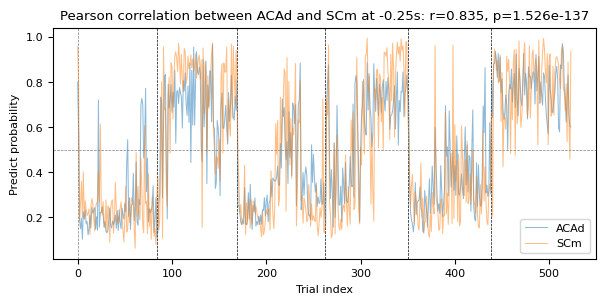

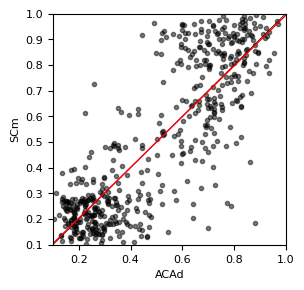

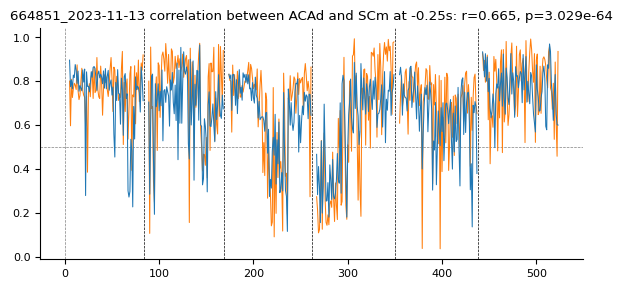

In [66]:
#example correlations

sel_session="664851_2023-11-13"
sel_structure_0="ACAd"
sel_structure_1="SCm"
# sel_session="670180_2023-07-27"
# sel_structure_0="PL"
# sel_structure_1="ACAd"
sel_time_bin=-0.25 #-0.25 #0.105
correction='flip_aud' #'subtract_mean' or 'flip_aud'
excl_instruction_trials=True
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

structure_results_0=get_session_structure_results(predict_proba_pd, sel_session, sel_structure_0, sel_unit_subsample_size, sel_time_aligned_to)
structure_results_1=get_session_structure_results(predict_proba_pd, sel_session, sel_structure_1, sel_unit_subsample_size, sel_time_aligned_to)

structure_results_0['bin_center']=structure_results_0['bin_center'].round(3)
structure_results_1['bin_center']=structure_results_1['bin_center'].round(3)

predict_proba_0=structure_results_0.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
predict_proba_1=structure_results_1.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]

trial_indices_0=structure_results_0.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]
trial_indices_1=structure_results_1.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]

session_trials=all_trials.filter(
    pl.col('session_id').eq(sel_session),
    pl.col('trial_index').is_in(trial_indices_0),
    pl.col('trial_index').is_in(trial_indices_1)
).sort('trial_index')

block_switches=session_trials.to_pandas().query('is_block_switch')['trial_index'].values

r,p=stats.pearsonr(predict_proba_0, predict_proba_1)

fig,ax=plt.subplots(1,1,figsize=(7,3))

for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(trial_indices_0, predict_proba_0, label=sel_structure_0, color='tab:blue', alpha=0.5, linewidth=0.75)
ax.plot(trial_indices_1, predict_proba_1, label=sel_structure_1, color='tab:orange', alpha=0.5, linewidth=0.75)
ax.set_title(f"Pearson correlation between {sel_structure_0} and {sel_structure_1} at {sel_time_bin}s: r={r:.3f}, p={p:.3e}")
ax.set_xlabel('Trial index')
ax.set_ylabel('Predict probability')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.plot(predict_proba_0,predict_proba_1,'k.',alpha=0.5)
#plot diagonal line
ax.plot([0, 1], [0, 1], color='black', linestyle='-', linewidth=0.5)
#fit line to data
fit_line = np.polyfit(predict_proba_0, predict_proba_1, 1)
ax.plot(np.array([0, 1]), np.polyval(fit_line, np.array([0, 1])), color='red', linestyle='-', linewidth=1)
ax.set_xlabel(sel_structure_0)
ax.set_ylabel(sel_structure_1)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.1, 1)

if (
    session_trials['block_index'].n_unique() == 1
    and not (
        session_table.filter(
            pl.col('session_id') == session_trials['session_id'][0],
            pl.col('is_templeton'),
        )
    ).is_empty()
):
    print(f'Adding dummy context labels for Templeton session {sel_session}')
    session_trials = (
        session_trials
        .with_columns(
            pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
            # short 7th block will sometimes be present: merge into 6th with clip
        )
        .with_columns(
            pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
            .then(pl.lit('vis'))
            .otherwise(pl.lit('aud'))
            .alias('rewarded_modality')
        )
        .sort('trial_index')
    )

session_trials = session_trials.to_pandas()

session_trials['predict_proba_0']=predict_proba_0
session_trials['predict_proba_1']=predict_proba_1

if excl_instruction_trials:
    # session_trials=session_trials.query('~is_instruction').reset_index(drop=True)
    #replace is_instruction trials predict_proba with nan
    session_trials['predict_proba_0'] = session_trials['predict_proba_0'].where(~session_trials['is_instruction'], np.nan)
    session_trials['predict_proba_1'] = session_trials['predict_proba_1'].where(~session_trials['is_instruction'], np.nan)

corrected_predict_proba_0 = []
corrected_predict_proba_1 = []
for bb in session_trials['block_index'].unique():
    block_trials=session_trials.query(f'block_index=={bb}')
    if correction=='flip_aud':
        if block_trials['rewarded_modality'].values[0]=='vis':
            corrected_predict_proba_0.append(block_trials['predict_proba_0'].values)
            corrected_predict_proba_1.append(block_trials['predict_proba_1'].values)
        elif block_trials['rewarded_modality'].values[0]=='aud':
            corrected_predict_proba_0.append(1 - block_trials['predict_proba_0'].values)
            corrected_predict_proba_1.append(1 - block_trials['predict_proba_1'].values)
    elif correction=='subtract_mean':
        corrected_predict_proba_0.append(block_trials['predict_proba_0'].values - np.nanmean(block_trials['predict_proba_0'].values))
        corrected_predict_proba_1.append(block_trials['predict_proba_1'].values - np.nanmean(block_trials['predict_proba_1'].values))

corrected_predict_proba_0 = np.concatenate(corrected_predict_proba_0)
corrected_predict_proba_1 = np.concatenate(corrected_predict_proba_1)

r,p=stats.pearsonr(corrected_predict_proba_0[~np.isnan(corrected_predict_proba_0)], corrected_predict_proba_1[~np.isnan(corrected_predict_proba_1)])

fig,ax=plt.subplots(1,1,figsize=(7,3))
for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
if correction=='flip_aud':
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
elif correction=='subtract_mean':
    ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(trial_indices_1, corrected_predict_proba_1, label=sel_structure_1, color='tab:orange', alpha=1, linewidth=0.75,)
ax.plot(trial_indices_0, corrected_predict_proba_0, label=sel_structure_0, color='tab:blue', alpha=1, linewidth=0.75,)

ax.set_title(f"{sel_session} correlation between {sel_structure_0} and {sel_structure_1} at {sel_time_bin}s: r={r:.3f}, p={p:.3e}")

#remove top and right splines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [67]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\ACAd_SCm_predict_proba_corrected_-0.25.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [14]:
# average some areas together per session:

simplfied_structure_grouping = {
    'VIS': ['VISp', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor'],
    'AUD': ['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'AI': ['AIp', 'AIv', 'AId'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','MGd','MGv','MGm','LGd'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'AMY': ['BLAp','CEAm'],
    'BG': ['GP','GPe','GPi','SNr','SNc','VTA'],
    'LS': ['LSc','LSr','LSv'],
}


In [ ]:
# predict_proba_pd['structure'].unique()

In [ ]:
# predict_proba_pd.query('session_id=="636766_2023-01-24" and bin_center==-0.25')['predict_proba']

In [15]:
# for each session, get the average predict proba for each structure in the simplified_structure_grouping, and delete the original structure-session row

predict_proba_pd=predict_proba_pd[~predict_proba_pd['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg|ECT1|ECT2/3|ECT4|ECT5|ECT6a|ECT6b')]

sel_bin_center=-0.25
# sel_bin_center=0.155
new_predict_proba_pd = []

#round bin_center to 3 decimal places to avoid floating point issues
predict_proba_pd['bin_center']=predict_proba_pd['bin_center'].round(3)

#loop through each session
for sel_session in dr_session_list:
    print(f'Processing session {sel_session}')
    
    #get the table for the session
    predict_proba_pd_session=predict_proba_pd.query(f'session_id=="{sel_session}" and bin_center=={sel_bin_center}').reset_index(drop=True)

    #loop through each structure in the simplified_structure_grouping
    for new_structure, old_structures in simplfied_structure_grouping.items():
        if len(old_structures) > 1:
            #get the rows for the old structures
            old_structure_rows = predict_proba_pd_session.query(f'structure in {old_structures}')

            #check if length of predict_proba for each rows match
            if old_structure_rows['predict_proba'].apply(len).nunique() > 1:
                print(f'Warning: predict_proba lengths do not match for session {sel_session} and structures {old_structures}. Skipping...')
                continue

            if not old_structure_rows.empty:
                new_structure_row = {
                    'session_id': sel_session,
                    'structure': new_structure,
                    'unit_subsample_size': old_structure_rows['unit_subsample_size'].iloc[0],
                    'bin_center': old_structure_rows['bin_center'].iloc[0],
                    'time_aligned_to': old_structure_rows['time_aligned_to'].iloc[0],
                    'balanced_accuracy_test': old_structure_rows['balanced_accuracy_test'].mean(),
                    'total_n_units': old_structure_rows['total_n_units'].iloc[0],
                    'predict_proba': [old_structure_rows['predict_proba'].mean()],
                    'trial_index': [old_structure_rows['trial_index'].iloc[0]],
                    'is_vis_rewarded': [old_structure_rows['is_vis_rewarded'].iloc[0]],
                    'stim_name': [old_structure_rows['stim_name'].iloc[0]],
                    'is_response': [old_structure_rows['is_response'].iloc[0]],
                }

                predict_proba_pd_session = pd.concat([predict_proba_pd_session, pd.DataFrame(new_structure_row)], axis=0, ignore_index=True)
                
                #drop the old structure rows from the new_predict_proba_pd
                predict_proba_pd_session = predict_proba_pd_session.query(f'structure not in {old_structures}')


        else:
            #if only one old structure, just rename it to the new structure
            predict_proba_pd_session.loc[predict_proba_pd_session['session_id'] == sel_session, 'structure'] = old_structures[0]

    #update the new_predict_proba_pd with the session results
    # new_predict_proba_pd = pd.concat([new_predict_proba_pd, predict_proba_pd_session], axis=0, ignore_index=True)
    new_predict_proba_pd.append(predict_proba_pd_session)
    
    
new_predict_proba_pd = pd.concat(new_predict_proba_pd, axis=0, ignore_index=True)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20352\3707281372.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_proba_pd['bin_center']=predict_proba_pd['bin_center'].round(3)


Processing session 626791_2022-08-15
Processing session 626791_2022-08-16
Processing session 626791_2022-08-17
Processing session 636766_2023-01-23
Processing session 636766_2023-01-24
Processing session 636766_2023-01-25
Processing session 636766_2023-01-26
Processing session 644864_2023-01-30
Processing session 644864_2023-01-31
Processing session 644864_2023-02-02
Processing session 644866_2023-02-07
Processing session 644866_2023-02-08
Processing session 644866_2023-02-09
Processing session 644866_2023-02-10
Processing session 649943_2023-02-13
Processing session 649943_2023-02-14
Processing session 649943_2023-02-15
Processing session 649943_2023-02-16
Processing session 644867_2023-02-20
Processing session 644867_2023-02-22
Processing session 644867_2023-02-23
Processing session 660023_2023-08-09
Processing session 666986_2023-08-14
Processing session 666986_2023-08-15
Processing session 666986_2023-08-17
Processing session 662892_2023-08-21
Processing session 662892_2023-08-22
P

In [ ]:
new_predict_proba_pd

In [ ]:
# np.sort(predict_proba_pd['structure'].unique())
data_table['bin_center'].unique()

In [16]:
# get predict proba from each structure in this session (at selected time bin), correct it, append to the trials table, correlate across structures

sel_time_bin=-0.25
correction='flip_aud' #'subtract_mean' or 'flip_aud' or 'none'
excl_instruction_trials=True
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

data_table=new_predict_proba_pd.copy() #simplified structures
# data_table=predict_proba_pd.copy() #original with all structures
data_table['bin_center']=data_table['bin_center'].round(3)

predict_proba_corr_dict={
    'session_id':[],
    'time_bin':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
}

for sel_session in session_table.filter(pl.col('project')=="DynamicRouting",pl.col('is_production'),
                                        pl.col('issues').eq(""))['session_id'].unique().to_list():
# for sel_session in session_table.filter(pl.col('project')=="Templeton",pl.col('issues').eq(""))['session_id'].unique().to_list():

    session_structures=data_table.query(f'session_id=="{sel_session}"')['structure'].unique()
    session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

    if (
        session_trials['block_index'].n_unique() == 1
        and not (
            session_table.filter(
                pl.col('session_id') == session_trials['session_id'][0], 
                pl.col('is_templeton'),
            )
        ).is_empty()
    ):
        print(f'Adding dummy context labels for Templeton session {sel_session}')
        session_trials = (
            session_trials
            .with_columns(
                pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
                # short 7th block will sometimes be present: merge into 6th with clip
            )
            .with_columns(
                pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
                .then(pl.lit('vis'))
                .otherwise(pl.lit('aud'))
                .alias('rewarded_modality')
            )
            .sort('trial_index')
        )

    session_trials = session_trials.to_pandas()

    for sel_structure in session_structures:
        structure_results=get_session_structure_results(data_table, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
        structure_results['bin_center']=structure_results['bin_center'].round(3)
        predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
        
        #limit trial indices; assumes all results use the same trials
        trial_indices=structure_results.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]
        session_structure_trials=session_trials.query('trial_index in @trial_indices').sort_values(by='trial_index')

        if len(predict_proba)!=len(session_structure_trials):
            print(f"Skipping {sel_session}, {sel_structure} due to mismatch in number of trials between trials and predict_proba")
            predict_proba=np.array([np.nan]*len(session_structure_trials))

        temp_combined_trials=session_structure_trials.copy()
        temp_combined_trials['predict_proba']=predict_proba

        corrected_predict_proba = []
        for bb in temp_combined_trials['block_index'].unique():
            block_trials=temp_combined_trials.query(f'block_index=={bb}')
            if correction=='flip_aud':
                if block_trials['rewarded_modality'].values[0]=='vis':
                    corrected_predict_proba.append(block_trials['predict_proba'].values)
                elif block_trials['rewarded_modality'].values[0]=='aud':
                    corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
            elif correction=='subtract_mean':
                corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))
            elif correction=='none':
                corrected_predict_proba.append(block_trials['predict_proba'].values)

        corrected_predict_proba = np.concatenate(corrected_predict_proba)

        session_structure_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba

        session_trials=session_trials.merge(
            session_structure_trials[['trial_index', f'{sel_structure}_predict_proba']],
            on='trial_index',
            how='left',
        )

    # add a "behavior" column
    # -1 for response to non-rewarded target
    # 1 for no response to non-rewarded target
    # 0 for other stimuli
    session_trials['choice_predict_proba']=np.nan
    #false alarms
    session_trials.loc[
        (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=-1
    #correct rejects
    session_trials.loc[
        (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=1
    # #hits
    # session_trials.loc[
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1
    # #misses
    # session_trials.loc[
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

    for col0 in session_trials.filter(like='predict_proba').columns:
        for col1 in session_trials.filter(like='predict_proba').columns:
            if col0!=col1:
                if (np.sum(np.isnan(session_trials[col0]))>0)|(np.sum(np.isnan(session_trials[col1]))>0):
                    notnanidx=~np.isnan(session_trials[col0])&~np.isnan(session_trials[col1])
                    if sum(notnanidx)==0:
                        r=np.nan
                        p=np.nan
                    else:
                        r,p=stats.pearsonr(session_trials[col0][notnanidx], session_trials[col1][notnanidx])
                else:
                    r,p=stats.pearsonr(session_trials[col0], session_trials[col1])
                # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                predict_proba_corr_dict['session_id'].append(sel_session)
                predict_proba_corr_dict['time_bin'].append(sel_time_bin)
                predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
                predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
                predict_proba_corr_dict['r'].append(r)
                predict_proba_corr_dict['p'].append(p)

predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)

In [ ]:
# predict_proba.shape
# session_trials.shape

In [ ]:
# data_table.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]

In [ ]:
# structure_results=get_session_structure_results(data_table, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
# structure_results['bin_center'].unique()


# choice_values=session_trials['choice_predict_proba'].values
# not_nan_index=~np.isnan(choice_values)

# fig,ax=plt.subplots(1,1,figsize=(8,4))
# ax.plot(session_trials['MOs_predict_proba'])
# ax.plot(session_trials['trial_index'].values[not_nan_index],(choice_values[not_nan_index]+1)/2,)


Text(0.5, 1.0, '664851_2023-11-13 ACAd predict_proba at -0.25s\nr = 0.332, p = 3.108e-04')

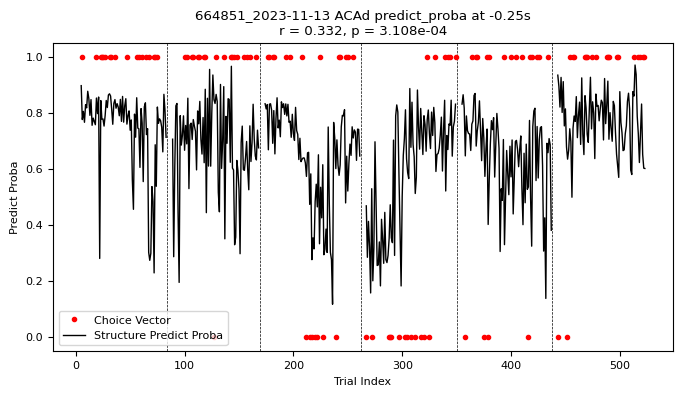

In [18]:
#plot example of predict proba and choice on same plot

sel_session="664851_2023-11-13"
sel_structure="ACAd"

correction='flip_aud' #'subtract_mean' or 'flip_aud' or 'none'
excl_instruction_trials=True
sel_time_bin=-0.25
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

structure_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
structure_results['bin_center']=structure_results['bin_center'].round(3)
predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
predict_proba_trial_indices=structure_results.query(f'bin_center==({sel_time_bin})')['trial_index'].values[0]
session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index').to_pandas()
block_switches=session_trials.query('is_block_switch').index.values
session_trials=session_trials.query('trial_index in @predict_proba_trial_indices').copy()

temp_combined_trials=session_trials.copy()
temp_combined_trials['predict_proba']=predict_proba

corrected_predict_proba = []
for bb in temp_combined_trials['block_index'].unique():
    block_trials=temp_combined_trials.query(f'block_index=={bb}')
    if correction=='flip_aud':
        if block_trials['rewarded_modality'].values[0]=='vis':
            corrected_predict_proba.append(block_trials['predict_proba'].values)
        elif block_trials['rewarded_modality'].values[0]=='aud':
            corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
    elif correction=='subtract_mean':
        corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))
    elif correction=='none':
        corrected_predict_proba.append(block_trials['predict_proba'].values)

corrected_predict_proba = np.concatenate(corrected_predict_proba)

session_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba

# add a "behavior" column
# -1 for response to non-rewarded target
# 1 for no response to non-rewarded target
session_trials['choice_predict_proba']=np.nan
#false alarms
session_trials.loc[
    (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
    (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
    ,'choice_predict_proba']=-1
#correct rejects
session_trials.loc[
    (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
    (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
    ,'choice_predict_proba']=1

if excl_instruction_trials:
    instruction_trials=session_trials.query('is_instruction').index.values
    session_trials.loc[instruction_trials,'choice_predict_proba']=np.nan
    session_trials.loc[instruction_trials,f'{sel_structure}_predict_proba']=np.nan


nanind=~np.isnan(session_trials['choice_predict_proba'])&~np.isnan(session_trials[f'{sel_structure}_predict_proba'])
r,p=stats.pearsonr(session_trials['choice_predict_proba'][nanind], session_trials[f'{sel_structure}_predict_proba'][nanind])

#plot predict_proba and choice on same plot
fig,ax=plt.subplots(1,1,figsize=(8,4))
for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
ax.plot(session_trials['trial_index'], (session_trials['choice_predict_proba']+1)/2, 'r.', label='Choice Vector')
ax.plot(session_trials['trial_index'], session_trials[f'{sel_structure}_predict_proba'], color='k', linewidth=1, label='Structure Predict Proba')
ax.set_xlabel('Trial Index')
ax.set_ylabel('Predict Proba')
ax.legend()
ax.set_title(f"{sel_session} {sel_structure} predict_proba at {sel_time_bin}s\nr = {r:.3f}, p = {p:.3e}")

In [ ]:
instruction_trials

In [ ]:
#compute mean correlation across sessions for each structure pair

unique_combos=predict_proba_corr_df[['structure_0','structure_1']].drop_duplicates().reset_index(drop=True)

mean_corr=unique_combos.copy()
mean_corr['mean_r']=np.nan
mean_corr['n_sessions']=0
for rr in range(len(unique_combos)):
    sel_structure_0=unique_combos.loc[rr,'structure_0']
    sel_structure_1=unique_combos.loc[rr,'structure_1']
    temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1')
    mean_corr.loc[rr,'mean_r']=temp_df['r'].mean()
    mean_corr.loc[rr,'n_sessions']=len(temp_df)


In [30]:
custom_incl_structures=True
# custom_incl_structures_list=[
#     'ACAd', 'ACAv', 'CA1', 'CA3', 'CP', 'DG', 'FRP',
#     'ILA', 'LP', 'MD', 'MOp', 'MOs', 'MRN', 'ORBl',
#     'ORBm', 'ORBvl', 'PL', 'RSPd', 'RSPv',
#     'SCm', 'SCs', 'SSp', 'SUB', 'VISp',
#     ]
# custom_incl_structures_list=[
#     'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
#     'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
#     'APN', 'MRN', 'SCm', 'SCs',
#     'CP', 'BG', 'LS',
#     'HPF', 
#     'THALpm', 'THALsm',
# ]

custom_incl_structures_list=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]

unique_structures=predict_proba_corr_df['structure_0'].sort_values().unique()

# unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
#                                                                  'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
#                                                                  'fiber tracts', 'scwm', 'VL', 'V3', 'V4','choice'])]
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=predict_proba_corr_df[['structure_0','structure_1']].value_counts()

if custom_incl_structures:
    incl_structures=custom_incl_structures_list
else:
    incl_structures=[]
    for st in unique_structures:
        if (predict_proba_corr_df[['structure_0','structure_1']].value_counts()[st]>=4).sum()>=20:
            incl_structures.append(st)

    incl_structures=np.sort(incl_structures)



#build correlation matrix from this dataframe
corr_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
for rr, sel_structure_0 in enumerate(incl_structures):
    for cc, sel_structure_1 in enumerate(incl_structures):
        if sel_structure_0==sel_structure_1:
            corr_matrix[rr,cc]=np.nan
        else:
            temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}"')
            #only save if at least 3 sessions
            if len(temp_df)>=3:
                corr_matrix[rr,cc]=temp_df['r'].mean()

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

In [ ]:
incl_structures

In [43]:
# custom_order=[
#     'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
#     'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
#     'APN', 'MRN', 'SCm', 'SCs',
#     'CP', 'BG', 'LS',
#     'HPF', 
#     'THALpm', 'THALsm',
# ]

custom_order=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]

custom_order_index=np.arange(len(custom_order),dtype=int)

custom_order_pd = pd.DataFrame({
    'structure': custom_order,
    'index': custom_order_index
})

custom_order_pd


,structure,index
0,ACAd,0
1,ACAv,1
2,AI,2
3,FRP,3
4,ILA,4
5,MOp,5
6,MOs,6
7,ORBl,7
8,ORBm,8
9,ORBvl,9


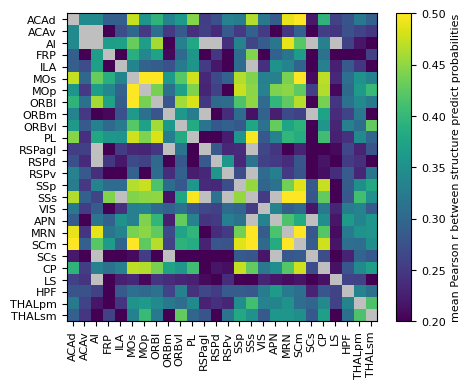

In [60]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.2, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [61]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\predict_proba_corr_matrix_corrected_custom_order_20_units_0.20-0.5.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [ ]:
masked_array[0]

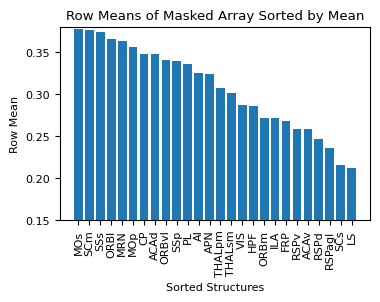

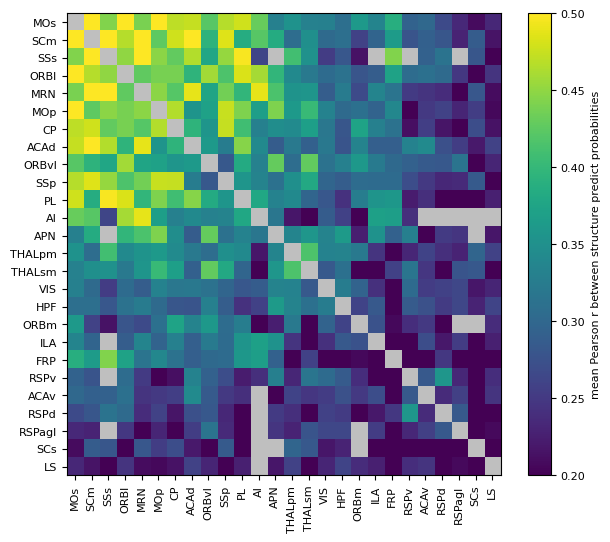

In [40]:
#sort by row mean
row_means = np.nanmean(corr_matrix, axis=1)
sort_idx = np.argsort(row_means)[::-1]
corr_matrix_sorted = corr_matrix[sort_idx][:,sort_idx]

masked_array_sorted = np.ma.array(corr_matrix_sorted, mask=np.isnan(corr_matrix_sorted))

labels_sorted = np.array(incl_structures)[sort_idx]

#plot row means
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(np.arange(len(row_means)), row_means[sort_idx])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
# ax.set_xticklabels(labels_sorted, rotation=90)
ax.set_xlabel('Sorted Structures')
ax.set_ylabel('Row Mean')
ax.set_ylim(0.15, 0.38)
ax.set_title('Row Means of Masked Array Sorted by Mean')


fig,ax=plt.subplots(1,1,figsize=(7,6))
im=ax.imshow(np.abs(masked_array_sorted), aspect='auto', cmap=cmap, vmin=0.2, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), labels_sorted, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), labels_sorted)
#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [ ]:
#plot just choice row

choices_df=pd.DataFrame({
    'structure': incl_structures,
    'r_with_choice': np.abs(corr_matrix[np.where(incl_structures=='choice')[0][0],:]),
    'bin_center': sel_time_bin,
})

fig,ax=plt.subplots(1,1,figsize=(7,3))
# choice_row=corr_matrix[np.where(incl_structures=='choice')[0][0],:]
# ax.bar(x=np.arange(len(incl_structures)), height=choice_row)
# ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
# ax.set_ylabel('mean Pearson r with choice')

choices_df.sort_values('r_with_choice', ascending=False).plot.bar(x='structure', y='r_with_choice', ax=ax, legend=False)
ax.set_ylabel('mean Pearson r with choice')
# ax.set_ylim(-0.01, 0.45)
fig.tight_layout()

In [ ]:
# choices_df_aud=choices_df.copy()

choice_merged_df=pd.merge(choices_df, choices_df_aud, on='structure', suffixes=('_vis', '_aud'))

fig,ax=plt.subplots(1,1,figsize=(7,3))
choice_merged_df.sort_values('r_with_choice_vis', ascending=False).plot.bar(x='structure', y=['r_with_choice_vis', 'r_with_choice_aud'], ax=ax, legend=True)
ax.set_ylabel('mean Pearson r with choice')
fig.tight_layout()


In [50]:
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

cluster_corr_matrix=np.abs(corr_matrix.copy())

# for rowind in range(cluster_corr_matrix.shape[0]):
#     for colind in range(cluster_corr_matrix.shape[1]):
#         if rowind==colind:
#             cluster_corr_matrix[rowind, colind] = np.nanmean(cluster_corr_matrix)
#         else:
#             cluster_corr_matrix[rowind, colind] = np.nanmean([cluster_corr_matrix[rowind, :],cluster_corr_matrix[:, colind]])
cluster_corr_matrix[np.isnan(cluster_corr_matrix)]=np.nanmean(cluster_corr_matrix)

data=cluster_corr_matrix.copy()

model = SpectralBiclustering(n_clusters=2, method="log", random_state=0,)# svd_method='arpack', n_init=25)
# model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(data)

# score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

# print("consensus score: {:.3f}".format(score))


#switch cluster order?
switch_cluster_order=[1,0]
if switch_cluster_order is not None:
    model.row_labels_ = np.array([switch_cluster_order[label] for label in model.row_labels_])
    model.column_labels_ = np.array([switch_cluster_order[label] for label in model.column_labels_])

custom_order_pd_copy=custom_order_pd.copy()

if custom_incl_structures:
    custom_order_pd_copy['cluster'] = model.row_labels_
    custom_order_pd_copy.sort_values(by=['cluster', 'index'], inplace=True)
    sort_idx=custom_order_pd_copy.index.values
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]
    
else:
    sort_idx = np.argsort(model.row_labels_)
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]

In [ ]:
# custom_order_pd['cluster'] = model.row_labels_
# custom_order_pd.sort_values(by=['cluster', 'index'], inplace=True)
# custom_order_pd

In [ ]:
sort_idx

In [ ]:
# reordered_indices
# np.argsort(model.row_labels_)

In [ ]:
##TODO: Figure out a clustering score
## try other clustering methods?
### PROPERLY deal with nans

In [ ]:
# sort_idx
np.array(incl_structures)[sort_idx]

In [ ]:
model.row_labels_[sort_idx]


Text(0.5, 1.0, 'Spectral biclustering of structure predict probability correlations\nbin_center=-0.25s, correction=flip_aud, excl_instruction_trials=True')

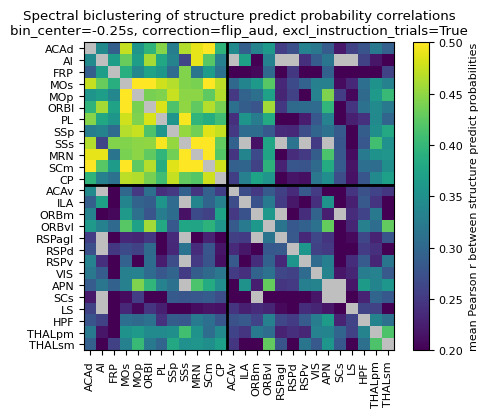

In [ ]:
masked_array = np.ma.array(fit_data, mask=np.isnan(fit_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.2, vmax=0.5, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), np.array(incl_structures)[sort_idx], rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), np.array(incl_structures)[sort_idx])

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

ax.set_title(f'Spectral biclustering of structure predict probability correlations\nbin_center={sel_time_bin}s, correction={correction}, excl_instruction_trials={excl_instruction_trials}')

In [63]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\predict_proba_corr_matrix_corrected_clustered_custom_order_20_units_0.2-0.5.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [ ]:
# import sklearn.cluster.HDBSCAN as hdbscan
import hdbscan

cluster_corr_matrix=corr_matrix.copy()
data=cluster_corr_matrix.copy()

model = hdbscan.HDBSCAN(min_cluster_size=2)

# model.fit_predict(data)


In [ ]:
#from stackexchange
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            print("Converged after {} iterations".format(i))
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [ ]:
data=corr_matrix.copy()
labels, centroids, X_hat = kmeans_missing(data, n_clusters=2)

fit_data=X_hat[np.argsort(labels)]

fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(fit_data, aspect='auto', cmap='viridis', vmin=0, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
# ax.set_xticks(np.arange(len(labels)), incl_structures[np.argsort(labels)], rotation=90)
ax.set_xticks(np.arange(len(labels)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(labels)), incl_structures[np.argsort(labels)])

sorted_row_labels = labels[np.argsort(labels)]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    # ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')